### 1. Read data

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [30]:
full_df = pd.read_csv(f"E:/DS2023/github-hth/seminar_1/Datasets/revenue_train_data_by_date_store.csv")

In [31]:
df = full_df[["store_id", "date", "revenue"]]

In [32]:
store = "CA_3"
store_df = df[df['store_id'] == store]
store_df.head()

,store_id,date,revenue
2,CA_3,2011-01-29,11679.83
12,CA_3,2011-01-30,12161.46
22,CA_3,2011-01-31,9123.86
32,CA_3,2011-02-01,10249.78
42,CA_3,2011-02-02,9538.65


In [33]:
print(store_df.head())
print(store_df.info())

   store_id        date   revenue
2      CA_3  2011-01-29  11679.83
12     CA_3  2011-01-30  12161.46
22     CA_3  2011-01-31   9123.86
32     CA_3  2011-02-01  10249.78
42     CA_3  2011-02-02   9538.65
<class 'pandas.core.frame.DataFrame'>
Index: 1913 entries, 2 to 19122
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   store_id  1913 non-null   object 
 1   date      1913 non-null   object 
 2   revenue   1913 non-null   float64
dtypes: float64(1), object(2)
memory usage: 59.8+ KB
None


In [34]:
store_df = store_df.sort_values(["store_id", "date"])  # Sắp xếp dữ liệu nhưng giữ nguyên cột 'date'


### 2. EDA data

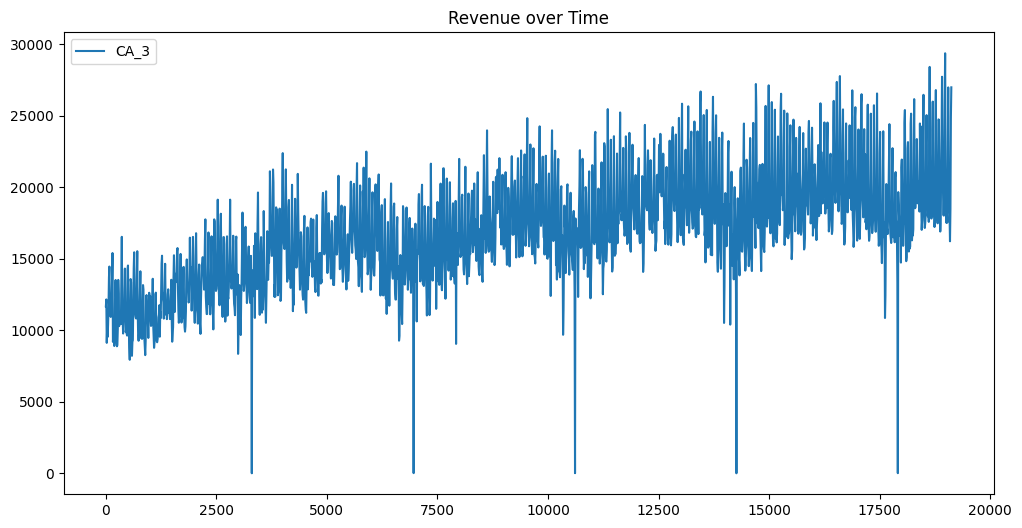

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
for store in store_df["store_id"].unique():
    store_df[store_df["store_id"] == store]["revenue"].plot(label=store)
plt.legend()
plt.title("Revenue over Time")
plt.show()


#### Kiểm tra tính dừng

In [36]:
#Kiểm tra tính dừng của dữ liệu
# Dùng kiểm định Augmented Dickey-Fuller (ADF):
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Chuỗi dừng' if result[1] < 0.05 else 'Chuỗi không dừng')

# Kiểm tra từng cửa hàng
for store in store_df["store_id"].unique():
    print(f"Store: {store}")
    adf_test(store_df[store_df["store_id"] == store]["revenue"])
    print("-" * 50)
# Nếu dữ liệu không dừng (p-value > 0.05), ta sẽ phải lấy sai phân.


Store: CA_3
ADF Statistic: -1.7572468532843348
p-value: 0.40188434959280683
Chuỗi không dừng
--------------------------------------------------


**Lấy sai phân bậc 1**

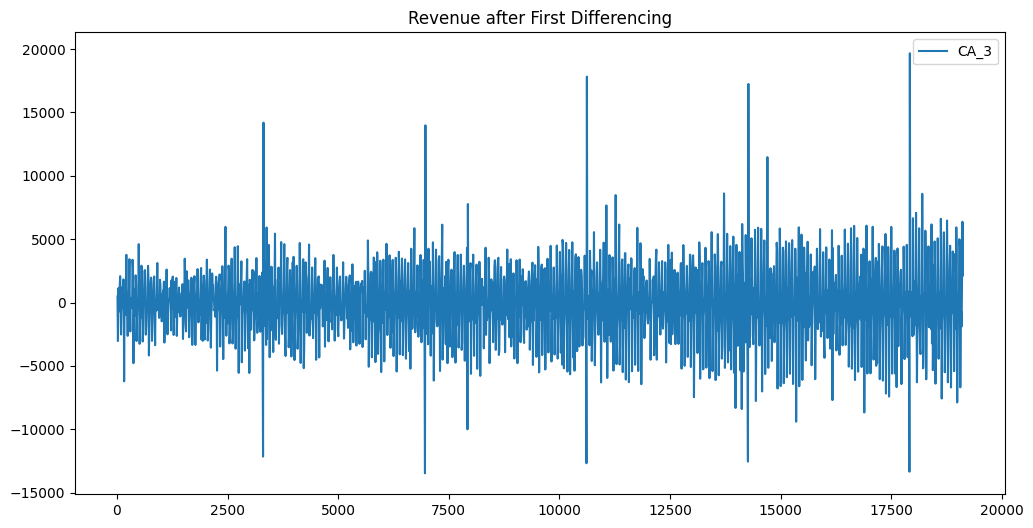

In [37]:
# Thực hiện sai phân lần thứ nhất (d = 1)
# Sai phân bậc 1 giúp loại bỏ xu hướng tuyến tính trong chuỗi thời gian:
store_df["revenue_diff"] = store_df.groupby("store_id")["revenue"].diff()

# Vẽ chuỗi sau khi sai phân
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
for store in store_df["store_id"].unique():
    store_df[store_df["store_id"] == store]["revenue_diff"].dropna().plot(label=store)
plt.legend()
plt.title("Revenue after First Differencing")
plt.show()


**Kiểm tra tính dừng khi sai phân bậc 1**

In [38]:
# Kiểm tra lại tính dừng sau khi sai phân
# Sau khi sai phân, chạy lại kiểm định ADF để xem chuỗi đã dừng chưa:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series.dropna())  # Bỏ giá trị NaN sau khi sai phân
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Chuỗi dừng' if result[1] < 0.05 else 'Chuỗi không dừng')

# Kiểm tra lại từng cửa hàng
for store in store_df["store_id"].unique():
    print(f"Store: {store}")
    adf_test(store_df[store_df["store_id"] == store]["revenue_diff"])
    print("-" * 50)


Store: CA_3
ADF Statistic: -21.006311298189225
p-value: 0.0
Chuỗi dừng
--------------------------------------------------


**Kiểm định tính mùa vụ**

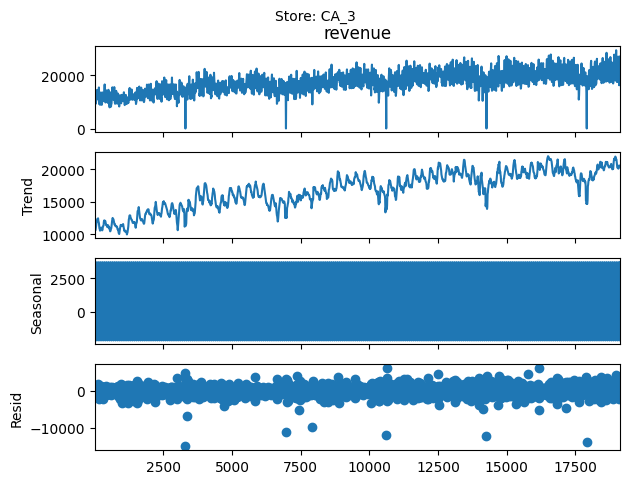

In [39]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Kiểm tra lại từng cửa hàng
for store in store_df["store_id"].unique():
    store_data = store_df[store_df["store_id"] == store]["revenue"]
    result = seasonal_decompose(store_data, model='additive', period=7)

    fig = result.plot()
    fig.suptitle(f"Store: {store}", fontsize=10, y=1.0)  # Đặt tiêu đề chính cho biểu đồ
    plt.show()


**Kết luận**
- Trend (Xu hướng)

  - Đường Trend có xu hướng tăng dần theo thời gian, cho thấy doanh thu có xu hướng phát triển theo năm.
  - Điều này gợi ý rằng mô hình cần xử lý xu hướng bằng sai phân bậc 1 (d = 1, như bạn đã kiểm tra trước đó).
- Seasonal (Tính mùa vụ)

  - Biểu đồ Seasonal cho thấy mô hình có dao động lặp lại theo năm (7 ngày).
  - Điều này khẳng định rằng dữ liệu có tính mùa vụ với chu kỳ s = 7.
- Residual (Phần dư)

  - Residual có vẻ khá ngẫu nhiên, không có mẫu rõ ràng, chứng tỏ decomposition đã tách tốt thành phần xu hướng và mùa vụ.

→ Kết luận: Dùng SARIMA thay vì ARIMA
- Thông số ban đầu:
  - (p, d, q): Xác định bằng ACF/PACF (sẽ làm bước tiếp theo).
  - (P, D, Q, s): Chu kỳ mùa vụ là 7 ngày → Thử (P, D, Q, 7) với D = 1.

**Tìm giá trị tham số**

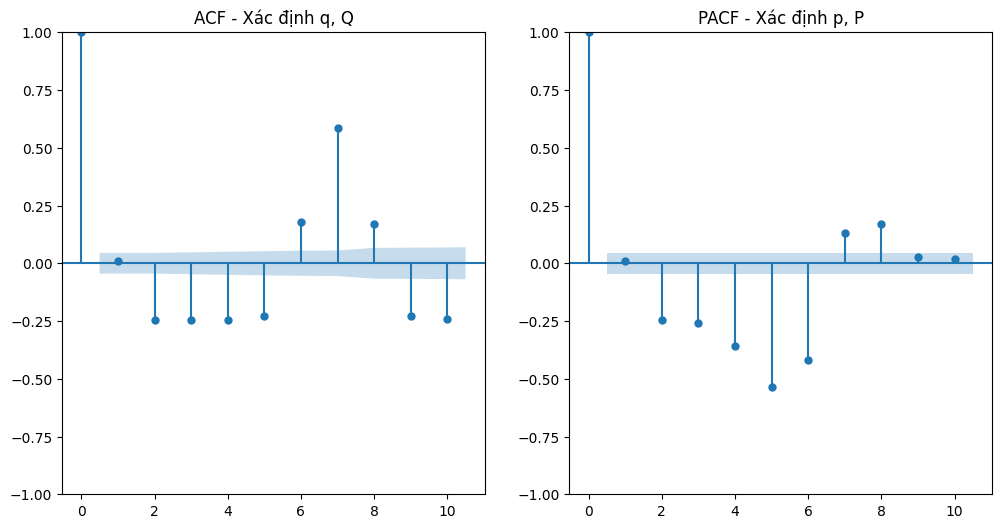

In [40]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

revenue_diff = store_df[store_df["store_id"] == store]["revenue"].diff().dropna()

plt.figure(figsize=(12,6))

# ACF để tìm q và Q
plt.subplot(121)
plot_acf(revenue_diff, lags=10, ax=plt.gca())  # Kiểm tra đến 10 ngày
plt.title("ACF - Xác định q, Q")

# PACF để tìm p và P
plt.subplot(122)
plot_pacf(revenue_diff, lags=10, ax=plt.gca())  # Kiểm tra đến 10 ngày
plt.title("PACF - Xác định p, P")

plt.show()


**Kết luận**
- Dựa vào biểu đồ ACF (bên trái) và PACF (bên phải), ta có thể xác định các tham số 𝑝,𝑞,𝑃,𝑄 cho mô hình SARIMA như sau:
1. Xác định 𝑞(MA) từ ACF
- CF (AutoCorrelation Function) giúp xác định 𝑞bằng cách nhìn vào nơi mà đồ thị cắt về 0 hoặc giảm dần.
- Trong biểu đồ, ACF có các spike giảm dần từ q = 1 trở đi.
2. Xác định p (AR) từ PACF
- PACF (Partial AutoCorrelation Function) giúp xác định p bằng cách tìm nơi PACF cắt về 0.
- Trong biểu đồ, PACF giảm dần từ p = 1 trở đi.
3. Xác định P,Q (thành phần mùa vụ)
- Vì dữ liệu có chu kỳ 7 ngày, ta nhìn vào ACF/PACF tại khoảng 7 hoặc các bội số của nó.
- Do không có spike mạnh ở các vị trí lớn (365, 30, 7), ta bắt đầu thử với P=1,Q=1.
4. Tổng hợp tham số SARIMA
- Dựa vào phân tích trên, ta thử các tham số:
`SARIMA(p,d,q)(P,D,Q,s)=(1,1,1)(1,1,1,7)`

### 3. Split test - validate - train dataset

In [41]:
# Chia tập dữ liệu
store_train_df = store_df[store_df['date'] < '2016-02-24']
store_val_df = store_df[(store_df['date'] >= '2016-02-24') & (store_df['date'] < '2016-03-24')]
store_test_df = store_df[store_df['date'] >= '2015-03-24']

### 4. Model

#### 4.1. ARIMA

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib

ARIMA(1, 1, 1) -> RMSE: 4178.482270631308, MAE: 2757.219752926298, MASE: 1.3310728496654025, RMSSE: 1.4752728625076899


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarn

ARIMA(1, 1, 2) -> RMSE: 3371.3225371945477, MAE: 2542.5114164266283, MASE: 1.2274204523516898, RMSSE: 1.1902935869420948


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarn

ARIMA(1, 1, 3) -> RMSE: 3370.963319790996, MAE: 2541.9315122690687, MASE: 1.2271404983586442, RMSSE: 1.1901667601057275


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarn

ARIMA(1, 1, 4) -> RMSE: 3227.116873352337, MAE: 2588.729574495757, MASE: 1.2497326874581112, RMSSE: 1.1393797170947595


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarn

ARIMA(1, 2, 1) -> RMSE: 4151.07631470051, MAE: 2732.5344336475073, MASE: 1.319155787834387, RMSSE: 1.4655967982247415


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarn

ARIMA(1, 2, 2) -> RMSE: 3321.80554513198, MAE: 2542.77429589423, MASE: 1.2275473597995592, RMSSE: 1.1728109054583515


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarn

ARIMA(1, 2, 3) -> RMSE: 3345.0481268065264, MAE: 2550.894381613965, MASE: 1.2314674048474825, RMSSE: 1.181017030979113


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarn

ARIMA(1, 2, 4) -> RMSE: 3321.3647629079846, MAE: 2580.571836458493, MASE: 1.2457944654123132, RMSSE: 1.172655280996832


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarn

ARIMA(2, 1, 1) -> RMSE: 3271.8520660580975, MAE: 2565.078405448253, MASE: 1.2383148710332261, RMSSE: 1.1551741159992903


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarn

ARIMA(2, 1, 2) -> RMSE: 3099.32583921404, MAE: 2488.0637777450506, MASE: 1.2011353608204391, RMSSE: 1.094261266775826


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, foreca

ARIMA(2, 1, 3) -> RMSE: 1758.5438322117056, MAE: 1409.0780581825343, MASE: 0.6802452159699703, RMSSE: 0.6208790238088624


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, foreca

ARIMA(2, 1, 4) -> RMSE: 1741.4314829323607, MAE: 1414.1015275588802, MASE: 0.682670341385122, RMSSE: 0.6148372644162214


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarn

ARIMA(2, 2, 1) -> RMSE: 3365.8799793335616, MAE: 2596.757802077886, MASE: 1.2536083871567536, RMSSE: 1.1883720141329015


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarn

ARIMA(2, 2, 2) -> RMSE: 3253.112161532527, MAE: 2575.903840617052, MASE: 1.2435409480710498, RMSSE: 1.1485577249745218


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarn

ARIMA(2, 2, 3) -> RMSE: 3385.5336855552946, MAE: 2716.4207096260006, MASE: 1.3113767413767135, RMSSE: 1.1953110359017411


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, foreca

ARIMA(2, 2, 4) -> RMSE: 3163.449915146294, MAE: 2482.426531975694, MASE: 1.1984139292832838, RMSSE: 1.1169011879072717


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarn

ARIMA(3, 1, 1) -> RMSE: 3129.895025343076, MAE: 2477.8641253660658, MASE: 1.1962113861016004, RMSSE: 1.105054154672488


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, foreca

ARIMA(3, 1, 2) -> RMSE: 2272.0122902077483, MAE: 1673.510442466324, MASE: 0.807902348456011, RMSSE: 0.8021663986912221


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, foreca

ARIMA(3, 1, 3) -> RMSE: 1750.196755311543, MAE: 1435.7930308342204, MASE: 0.6931421113800924, RMSSE: 0.6179319690567995


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, foreca

ARIMA(3, 1, 4) -> RMSE: 1738.528577602803, MAE: 1404.4695491530435, MASE: 0.6780204164268498, RMSSE: 0.6138123522165871


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarn

ARIMA(3, 2, 1) -> RMSE: 3279.1196402512314, MAE: 2708.0541514901547, MASE: 1.3073377095338752, RMSSE: 1.1577400368980695


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, foreca

ARIMA(3, 2, 2) -> RMSE: 3118.104275758543, MAE: 2492.6642253221753, MASE: 1.2033562686242951, RMSSE: 1.1008912620803752


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, foreca

ARIMA(3, 2, 3) -> RMSE: 3773.5607848928676, MAE: 2876.9123351813073, MASE: 1.3888555296193295, RMSSE: 1.332309546962507


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, foreca

ARIMA(3, 2, 4) -> RMSE: 3669.9901240522445, MAE: 2806.073101765418, MASE: 1.354657247022911, RMSSE: 1.295742445466328


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarn

ARIMA(4, 1, 1) -> RMSE: 2810.846555789911, MAE: 2166.8696701978984, MASE: 1.0460759914775446, RMSSE: 0.9924095343363862


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, foreca

ARIMA(4, 1, 2) -> RMSE: 1874.5289321821858, MAE: 1438.645428820178, MASE: 0.6945191323852259, RMSSE: 0.6618292204016168


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, foreca

ARIMA(4, 1, 3) -> RMSE: 1769.291024153126, MAE: 1433.1515435125766, MASE: 0.6918669094115718, RMSSE: 0.6246734734660446


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, foreca

ARIMA(4, 1, 4) -> RMSE: 1901.690483450557, MAE: 1456.2490366199368, MASE: 0.7030174337533154, RMSSE: 0.6714189941267511


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarn

ARIMA(4, 2, 1) -> RMSE: 3252.264740965669, MAE: 2677.5256192277548, MASE: 1.292599783624456, RMSSE: 1.148258531036521


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, foreca

ARIMA(4, 2, 2) -> RMSE: 2801.1846544531745, MAE: 2177.526921691474, MASE: 1.0512208763203645, RMSSE: 0.9889982620324451


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib

ARIMA(4, 2, 4) -> RMSE: 3788.709276950185, MAE: 2889.9171800110526, MASE: 1.395133736442929, RMSSE: 1.337657938505807
    p  d  q         RMSE          MAE      MASE     RMSSE
0   1  1  1  4178.482271  2757.219753  1.331073  1.475273
1   1  1  2  3371.322537  2542.511416  1.227420  1.190294
2   1  1  3  3370.963320  2541.931512  1.227140  1.190167
3   1  1  4  3227.116873  2588.729574  1.249733  1.139380
4   1  2  1  4151.076315  2732.534434  1.319156  1.465597
5   1  2  2  3321.805545  2542.774296  1.227547  1.172811
6   1  2  3  3345.048127  2550.894382  1.231467  1.181017
7   1  2  4  3321.364763  2580.571836  1.245794  1.172655
8   2  1  1  3271.852066  2565.078405  1.238315  1.155174
9   2  1  2  3099.325839  2488.063778  1.201135  1.094261
10  2  1  3  1758.543832  1409.078058  0.680245  0.620879
11  2  1  4  1741.431483  1414.101528  0.682670  0.614837
12  2  2  1  3365.879979  2596.757802  1.253608  1.188372
13  2  2  2  3253.112162  2575.903841  1.243541  1.148558
14  2  2  3 

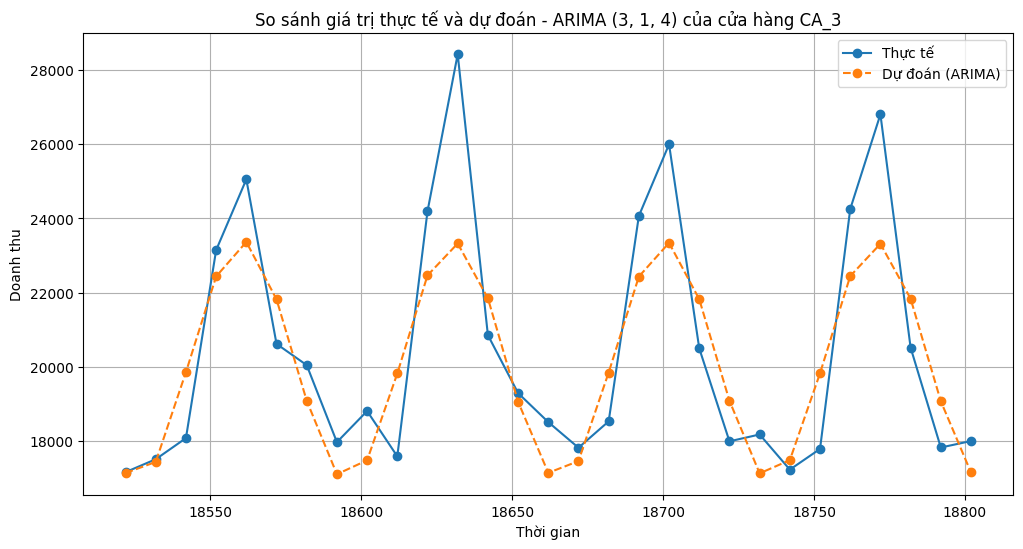

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Hàm tính MASE và RMSSE
def mase(actual, predicted, naive_diff):
    mae = mean_absolute_error(actual, predicted)
    naive_mae = np.mean(np.abs(naive_diff))
    return mae / naive_mae if naive_mae != 0 else np.nan

def rmsse(actual, predicted, naive_diff):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    naive_rmse = np.sqrt(np.mean(naive_diff ** 2))
    return rmse / naive_rmse if naive_rmse != 0 else np.nan

# Danh sách tham số
p_values = [1, 2, 3, 4]
d_values = [1, 2]
q_values = [1, 2, 3, 4]

# Biến lưu kết quả tốt nhất
best_params = None
best_rmse = float('inf')
best_forecast = None

# Dữ liệu huấn luyện và kiểm tra
train, test = store_train_df['revenue'], store_val_df['revenue']

# Tính độ chênh lệch của naive forecast (dự báo đơn giản)
naive_diff = np.diff(train)

results = []

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(train, order=(p, d, q)).fit()
                predictions = model.predict(start=len(train), end=len(train) + len(test) - 1)

                # Tính các chỉ số đánh giá
                mae = mean_absolute_error(test, predictions)
                rmse = np.sqrt(mean_squared_error(test, predictions))
                mase_value = mase(test, predictions, naive_diff)
                rmsse_value = rmsse(test, predictions, naive_diff)

                results.append({
                    'p': p, 'd': d, 'q': q,
                    'RMSE': rmse, 'MAE': mae, 'MASE': mase_value, 'RMSSE': rmsse_value
                })
                
                print(f'ARIMA({p}, {d}, {q}) -> RMSE: {rmse}, MAE: {mae}, MASE: {mase_value}, RMSSE: {rmsse_value}')
                
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params = (p, d, q)
                    best_forecast = predictions
            except:
                continue

# Chuyển kết quả thành DataFrame
results_df = pd.DataFrame(results)

# In bảng kết quả
print(results_df)
print(f'Best ARIMA order: {best_params} with RMSE: {best_rmse}')

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Thực tế', marker='o', linestyle='-')
plt.plot(test.index, best_forecast, label='Dự đoán (ARIMA)', marker='o', linestyle='--')

# Định dạng biểu đồ
plt.xlabel('Thời gian')
plt.ylabel('Doanh thu')
plt.title(f'So sánh giá trị thực tế và dự đoán - ARIMA {best_params} của cửa hàng {store}')
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()


**Kết quả:** Best ARIMA order: (3, 1, 4) with RMSE: 1738.528577602803

#### 4.2. SARIMA

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.p

SARIMA(1, 1, 1) x (1, 1, 1, 7) -> RMSE: 1064.3756442214285, MAE: 696.6681889214599, MASE: 0.3363228884874851, RMSSE: 0.3757930276432098


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, foreca

SARIMA(1, 1, 1) x (1, 1, 2, 7) -> RMSE: 1058.8756598142845, MAE: 735.7686842900924, MASE: 0.3551990073526635, RMSSE: 0.3738511795714579


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarn

SARIMA(1, 1, 1) x (2, 1, 1, 7) -> RMSE: 1204.6709124006647, MAE: 823.4421881840633, MASE: 0.39752418674558004, RMSSE: 0.42532627643495236


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, foreca

SARIMA(1, 1, 1) x (2, 1, 2, 7) -> RMSE: 1045.482117635391, MAE: 758.0546543835305, MASE: 0.36595776159716914, RMSSE: 0.36912239815523606


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, foreca

SARIMA(1, 1, 2) x (1, 1, 1, 7) -> RMSE: 1478.2824191768138, MAE: 1067.8087214381057, MASE: 0.5154943476063883, RMSSE: 0.5219287279168646


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, foreca

SARIMA(1, 1, 2) x (1, 1, 2, 7) -> RMSE: 1316.4973512398044, MAE: 914.6854399865526, MASE: 0.44157269432665996, RMSSE: 0.464808198301605


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, foreca

SARIMA(1, 1, 2) x (2, 1, 1, 7) -> RMSE: 987.5336516596409, MAE: 668.5165224470278, MASE: 0.3227324161005154, RMSSE: 0.3486628643482258


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, foreca

SARIMA(1, 1, 2) x (2, 1, 2, 7) -> RMSE: 20696.29871572501, MAE: 20440.92724137931, MASE: 9.868043069149305, RMSSE: 7.3071239440843225


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


SARIMA(2, 1, 1) x (1, 1, 1, 7) -> RMSE: 1453.5827880450495, MAE: 1082.6228209113162, MASE: 0.5226459885229694, RMSSE: 0.5132081702687555


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: Value

SARIMA(2, 1, 1) x (1, 1, 2, 7) -> RMSE: 1398.4441974323265, MAE: 1015.3883075757051, MASE: 0.49018791724790456, RMSSE: 0.4937407031026016


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, foreca

SARIMA(2, 1, 1) x (2, 1, 1, 7) -> RMSE: 1459.553997837598, MAE: 1089.5931723830101, MASE: 0.5260109889320772, RMSSE: 0.5153163911950959


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\st

SARIMA(2, 1, 2) x (1, 1, 1, 7) -> RMSE: 1498.7117777131814, MAE: 1158.8778508772127, MASE: 0.5594587960368794, RMSSE: 0.5291416048169237


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\st

SARIMA(2, 1, 2) x (1, 1, 2, 7) -> RMSE: 1356.747172585142, MAE: 953.0790461811647, MASE: 0.4601075560300679, RMSSE: 0.4790189727660346


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, foreca

SARIMA(2, 1, 2) x (2, 1, 1, 7) -> RMSE: 1441.1980137171142, MAE: 1074.370197876529, MASE: 0.5186619598838048, RMSSE: 0.5088355487543117


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


SARIMA(2, 1, 2) x (2, 1, 2, 7) -> RMSE: 1294.3163016297592, MAE: 911.1455775566382, MASE: 0.4398637936244185, RMSSE: 0.45697686184204106
    p  d  q  P  D  Q  s          RMSE           MAE      MASE     RMSSE
0   1  1  1  1  1  1  7   1064.375644    696.668189  0.336323  0.375793
1   1  1  1  1  1  2  7   1058.875660    735.768684  0.355199  0.373851
2   1  1  1  2  1  1  7   1204.670912    823.442188  0.397524  0.425326
3   1  1  1  2  1  2  7   1045.482118    758.054654  0.365958  0.369122
4   1  1  2  1  1  1  7   1478.282419   1067.808721  0.515494  0.521929
5   1  1  2  1  1  2  7   1316.497351    914.685440  0.441573  0.464808
6   1  1  2  2  1  1  7    987.533652    668.516522  0.322732  0.348663
7   1  1  2  2  1  2  7  20696.298716  20440.927241  9.868043  7.307124
8   2  1  1  1  1  1  7   1453.582788   1082.622821  0.522646  0.513208
9   2  1  1  1  1  2  7   1398.444197   1015.388308  0.490188  0.493741
10  2  1  1  2  1  1  7   1459.553998   1089.593172  0.526011  0.515316

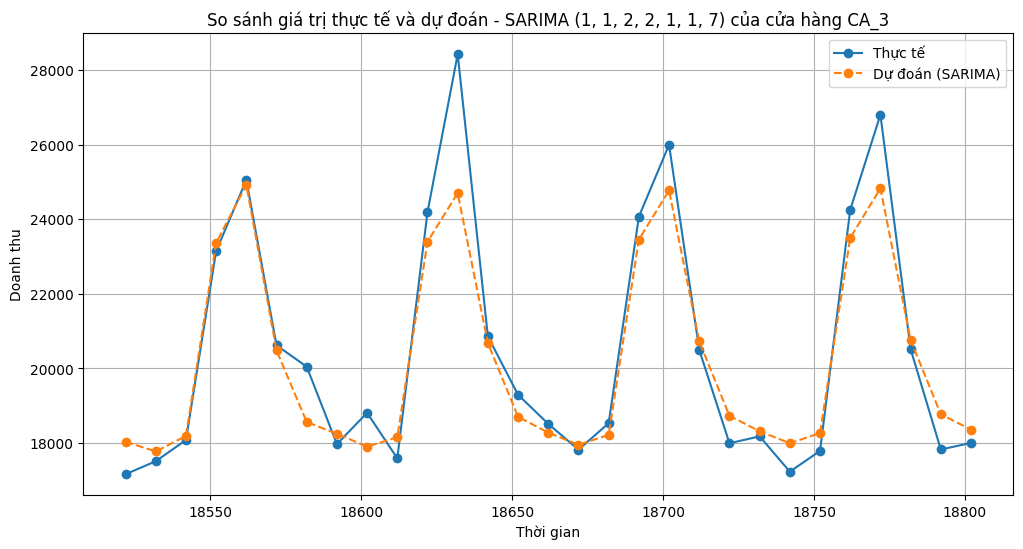

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Hàm tính MASE và RMSSE
def mase(actual, predicted, naive_diff):
    mae = mean_absolute_error(actual, predicted)
    naive_mae = np.mean(np.abs(naive_diff))
    return mae / naive_mae if naive_mae != 0 else np.nan

def rmsse(actual, predicted, naive_diff):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    naive_rmse = np.sqrt(np.mean(naive_diff ** 2))
    return rmse / naive_rmse if naive_rmse != 0 else np.nan

# Tạo danh sách tham số
p_values = [1,2]
d_values = [1]
q_values = [1,2]
P_values = [1,2]
D_values = [1]
Q_values = [1,2]
s_values = [7]  # Chu kỳ theo mùa
# Biến lưu kết quả tốt nhất
best_params = None
best_rmse = float('inf')
best_forecast = None

# Dữ liệu huấn luyện và kiểm tra
train, test = store_train_df['revenue'], store_val_df['revenue']

# Tính độ chênh lệch của naive forecast (dự báo đơn giản)
naive_diff = np.diff(train)

results = []

for p in p_values:
    for d in d_values:
        for q in q_values:
            for P in P_values:
                for D in D_values:
                    for Q in Q_values:
                        for s in s_values:
                            try:
                                model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s)).fit()
                                predictions = model.predict(start=len(train), end=len(train) + len(test) - 1)
                                
                                # Tính các chỉ số đánh giá
                                mae = mean_absolute_error(test, predictions)
                                rmse = np.sqrt(mean_squared_error(test, predictions))
                                mase_value = mase(test, predictions, naive_diff)
                                rmsse_value = rmsse(test, predictions, naive_diff)

                                results.append({
                                    'p': p, 'd': d, 'q': q, 'P': P, 'D': D, 'Q': Q, 's': s,
                                    'RMSE': rmse, 'MAE': mae, 'MASE': mase_value, 'RMSSE': rmsse_value
                                })
                                
                                print(f'SARIMA({p}, {d}, {q}) x ({P}, {D}, {Q}, {s}) -> RMSE: {rmse}, MAE: {mae}, MASE: {mase_value}, RMSSE: {rmsse_value}')
                                
                                if rmse < best_rmse:
                                    best_rmse = rmse
                                    best_params = (p, d, q, P, D, Q, s)
                                    best_forecast = predictions
                            except:
                                continue

# Chuyển kết quả thành DataFrame
results_df = pd.DataFrame(results)

# In bảng kết quả
print(results_df)
print(f'Best SARIMA order: {best_params} with RMSE: {best_rmse}')

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Thực tế', marker='o', linestyle='-')
plt.plot(test.index, best_forecast, label='Dự đoán (SARIMA)', marker='o', linestyle='--')

# Định dạng biểu đồ
plt.xlabel('Thời gian')
plt.ylabel('Doanh thu')
plt.title(f'So sánh giá trị thực tế và dự đoán - SARIMA {best_params} của cửa hàng {store}')
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()


### 5. Result

#### 5.1. Compare ARIMA and SARIMA

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib

ARIMA: MAE=1404.47, RMSE=1738.53
SARIMA: MAE=20440.93, RMSE=20696.30


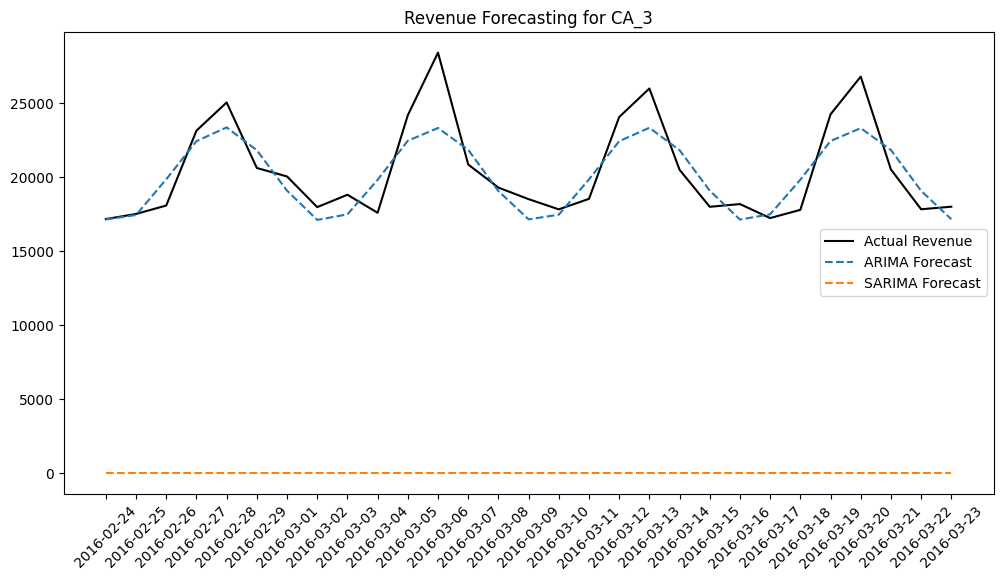

In [44]:
# Huấn luyện và dự báo với ARIMA
arima_model = ARIMA(store_train_df['revenue'], order=(3, 1, 4)).fit()
arima_forecast = arima_model.predict(start=len(store_train_df), end=len(store_train_df) + len(store_val_df) - 1)

# Huấn luyện và dự báo với SARIMA
sarima_model = SARIMAX(store_train_df['revenue'], order=(1, 1, 2), seasonal_order=(2, 1, 2, 7)).fit()
sarima_forecast = sarima_model.predict(start=len(store_train_df), end=len(store_train_df) + len(store_val_df) - 1)

# Đánh giá mô hình
def evaluate(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred))
    }

actuals = store_val_df['revenue'].values
results = {
    "ARIMA": evaluate(actuals, arima_forecast),
    "SARIMA": evaluate(actuals, sarima_forecast)
}

# Hiển thị kết quả
for model, scores in results.items():
    print(f"{model}: MAE={scores['MAE']:.2f}, RMSE={scores['RMSE']:.2f}")

# Vẽ biểu đồ so sánh
def plot_forecasts():
    plt.figure(figsize=(12,6))
    plt.plot(store_val_df['date'].values, actuals, label="Actual Revenue", color='black')
    plt.plot(store_val_df['date'].values, arima_forecast, label="ARIMA Forecast", linestyle='dashed')
    plt.plot(store_val_df['date'].values, sarima_forecast, label="SARIMA Forecast", linestyle='dashed')
    plt.legend()
    plt.title(f'Revenue Forecasting for {store}')
    plt.xticks(rotation=45)
    plt.show()

plot_forecasts()

#### 5.2. Predict for 28 following days

In [45]:
# Tạo danh sách lưu kết quả dự báo
forecast_results = []

# Lặp qua từng cửa hàng
for store in store_df['store_id'].unique():
    # Lọc dữ liệu theo store_id
    store_data = store_df[store_df['store_id'] == store]
    
    # Huấn luyện lại mô hình với toàn bộ dữ liệu của cửa hàng đó
    model = SARIMAX(store_data['revenue'], order=(1, 1, 2), seasonal_order=(2, 1, 1, 7)).fit()
    
    # Dự báo 28 ngày tiếp theo
    future_forecast = model.predict(start=len(store_data), end=len(store_data) + 27)
    
    # Tạo DataFrame cho kết quả dự báo
    forecast_df = pd.DataFrame({
        'date': pd.date_range(start=store_data['date'].iloc[-1], periods=29, freq='D')[1:],  # Ngày tiếp theo
        'forecast_revenue': future_forecast.values  # Doanh thu dự báo
    })
    
    # Lưu kết quả vào danh sách
    forecast_results.append(forecast_df)

# Gộp tất cả dự báo của các cửa hàng thành một DataFrame
final_forecast_df = pd.concat(forecast_results, ignore_index=True)

# Hiển thị bảng kết quả
print(final_forecast_df)


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\st

         date  forecast_revenue
0  2016-04-25      21224.193325
1  2016-04-26      19184.816579
2  2016-04-27      18465.193989
3  2016-04-28      17911.394323
4  2016-04-29      18751.256264
5  2016-04-30      23689.061987
6  2016-05-01      25570.763523
7  2016-05-02      20747.910349
8  2016-05-03      18826.231863
9  2016-05-04      18191.252274
10 2016-05-05      17724.402612
11 2016-05-06      18602.990363
12 2016-05-07      23495.452859
13 2016-05-08      25274.800775
14 2016-05-09      20627.382211
15 2016-05-10      18715.351791
16 2016-05-11      18108.990852
17 2016-05-12      17730.758704
18 2016-05-13      18558.888710
19 2016-05-14      23388.863395
20 2016-05-15      25153.640499
21 2016-05-16      20577.639658
22 2016-05-17      18678.063461
23 2016-05-18      18083.568782
24 2016-05-19      17722.921954
25 2016-05-20      18550.619007
26 2016-05-21      23374.278976
27 2016-05-22      25134.725240


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [46]:
# Thêm cột id bắt đầu từ 1914 tăng dần
final_forecast_df["id"] = range(1914, 1914 + len(final_forecast_df))

# Thêm cột d_id bắt đầu từ "d_1994" tăng dần
final_forecast_df["d_id"] = [f"d_{1994 + i}" for i in range(len(final_forecast_df))]

# Đặt lại tên cột store_id thành CA_3
final_forecast_df.rename(columns={"forecast_revenue": "CA_3"}, inplace=True)

# Hiển thị DataFrame kết quả
print(final_forecast_df.head())


        date          CA_3    id    d_id
0 2016-04-25  21224.193325  1914  d_1994
1 2016-04-26  19184.816579  1915  d_1995
2 2016-04-27  18465.193989  1916  d_1996
3 2016-04-28  17911.394323  1917  d_1997
4 2016-04-29  18751.256264  1918  d_1998


In [47]:
final_forecast_df.to_csv(f"E:/DS2023/github-hth/seminar_1/Evaluation/Result/Huong/CA_3_SARIMA.csv", index=False)